In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
# import random


%matplotlib inline

In [2]:
 def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


In [4]:
node_feature = np.load('../data/X_np/X.npy')
node_feature2= np.zeros(shape=[850,1879],dtype=np.float32)
node_feature2[:,0:256]=node_feature[:, 0:256]

for i in range(0,850):
    for j in range(0,1623):
        try:
            node_feature2[i][j+256]=max(node_feature[i,256+5*j: 256+j*5+5]) 
        except:
            print(j)
            break
            
node_feature2/=node_feature2.sum(1, keepdims=True)   


In [178]:
class AutoEncoder(nn.Module):

    def __init__(self, input_dim):
        super(AutoEncoder,self).__init__()
 
        self.linear1=nn.Linear(input_dim,940)
        self.linear2=nn.Linear(940,400)
        self.linear3=nn.Linear(400,150)
        self.linear4=nn.Linear(150,12)
        self.linear5=nn.Linear(12,150)
        self.linear6=nn.Linear(150,400)
        self.linear7=nn.Linear(400,940)
        self.linear8=nn.Linear(940,input_dim)
    
    def forward(self, feature):
        self.h1 = F.relu(self.linear1( feature))
        self.h1 = F.normalize(self.h1)
        
        self.h2  = F.sigmoid(self.linear2(self.h1))
        self.h2 = F.normalize(self.h2)
        
        self.h3 = F.relu(self.linear3( self.h2))
        self.h3 = F.normalize(self.h3)
        
        self.h4  = F.sigmoid(self.linear4( self.h3))
#         self.h4 = F.normalize(self.h4)
        
        self.h5  = F.relu(self.linear5( self.h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = F.sigmoid(self.linear6( self.h5))
        self.h6 = F.normalize(self.h6)
        
        self.h7  = F.relu(self.linear7(self.h6))
        self.h7 = F.normalize(self.h7)
        
        self.h8  = self.linear8(self.h7)

        return  self.h8



In [179]:
# 超参数定义
LEARNING_RATE = 0.001
WEIGHT_DACAY = 1e-4
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
node_feature = np.load('../data/X_np/X.npy')
node_feature2= np.zeros(shape=[850,1879],dtype=np.float32)
node_feature2[:,0:256]=node_feature[:, 0:256]

for i in range(0,850):
    for j in range(0,1623):
        try:
            node_feature2[i][j+256]=max(node_feature[i,256+5*j: 256+j*5+5]) 
        except:
            print(j)
            break
            
node_feature2/=node_feature2.sum(1, keepdims=True)   

In [8]:
tensor_x = tensor_from_numpy(node_feature2, DEVICE)
labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1

train_mask=[True for i in range(0,850)]
tensor_train_mask = tensor_from_numpy(np.array(train_mask), DEVICE )


In [180]:
# 模型定义：Model, Loss, Optimizer
model = AutoEncoder(tensor_x.shape[1]).to(DEVICE)
criterion=nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [181]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
 
    for epoch in range(EPOCHS):
         
        logits = model(tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
 
    
        
        loss = criterion(train_mask_logits, tensor_x)
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
 
        loss_history.append(loss.item())
 
    return loss_history, model.h4

In [197]:
loss,feature_layer = train()
 
print(loss)

C:\Users\Chester_Zhang\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[7.767067472741473e-06, 5.906914793740725e-06, 4.5514657358580735e-06, 3.6637723042076686e-06, 3.129068545604241e-06, 2.833854068740038e-06, 2.677563315955922e-06, 2.590137910374324e-06, 2.5322062811028445e-06, 2.4892603960324777e-06]


In [198]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 

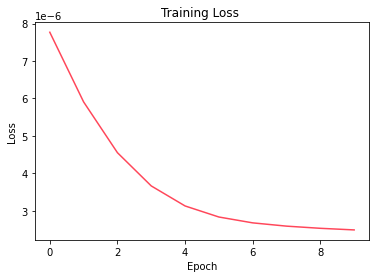

In [199]:
plot_loss_with_acc(loss, [])

In [200]:
feature_np=feature_layer.detach().numpy()
feature_np/=feature_np.sum(1, keepdims=True)

In [205]:
kmeans = KMeans(n_clusters=12,init='k-means++').fit(feature_np)

In [207]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print('purity : ',purity_score(labelList,kmeans.labels_ ))
print('ARI : ',adjusted_rand_score(labelList,kmeans.labels_))
print('NMI : ',normalized_mutual_info_score(labelList,kmeans.labels_ ))

purity :  0.6517647058823529
ARI :  0.4680553485635442
NMI :  0.659726172487363


In [108]:
# torch.save(model, '../model/autoencode.pt')
# np.save("../model/feacture_np.npy",feature_np )

In [109]:
class HalfAutoEncoder(nn.Module):
    def __init__(self,linear5,linear6,linear7,linear8 ):
        super(HalfAutoEncoder,self).__init__()
         
        self.linear5= linear5
        self.linear6= linear6
        self.linear7= linear7
        self.linear8= linear8
    
    def forward(self, h4):
        self.h5  = F.relu(self.linear5( h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = F.sigmoid(self.linear6( self.h5))
        self.h6 = F.normalize(self.h6)
        
        self.h7  = F.relu(self.linear7(self.h6))
        self.h7 = F.normalize(self.h7)
        
        self.h8  = self.linear8(self.h7)

        return  self.h8

In [110]:
half_auto_encoder=HalfAutoEncoder(model.linear5, model.linear6, model.linear7, model.linear8 ).to(DEVICE)

In [111]:
#  torch.save(half_auto_encoder, '../model/half_auto_encoder.pt')